Привет, меня зовут Артем. Сегодня я проверю твой проект.
<br> Дальнейшее общение будет происходить на "ты" если это не вызывает никаких проблем.
<br> Желательно реагировать на каждый мой комментарий ('исправил', 'не понятно как исправить ошибку', ...)
<br> Пожалуйста, не удаляй комментарии ревьюера, так как они повышают качество повторного ревью.

Комментарии будут в <font color='green'>зеленой</font>, <font color='blue'>синей</font> или <font color='red'>красной</font> рамках:

<div class="alert alert-block alert-success">
<b>Успех:</b> Если все сделано отлично
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Если можно немного улучшить
</div>

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Если требуются исправления. Работа не может быть принята с красными комментариями.
</div>

-------------------

Будет очень хорошо, если ты будешь помечать свои действия следующим образом:
<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> ...
</div>

<div class="alert alert-block alert-warning">
<b>Изменения:</b> Были внесены следующие изменения ...
</div>

#### <font color='orange'>Полезные ссылки:</font>
* Могу предложить обратить внимание на вот этот курс: https://vk.com/dlschool_mipt

### <font color='orange'>Общее впечатление</font>
* Большое спасибо за проделанную работу. Видно, что приложено много усилий.
* Над этим проектом нужно будет еще немного поработать. Однако, изменения не должны занять много времени.
* В работе я оставил несколько советов. Буду рад, если ты учтешь их.
* С радостью отвечу на твои вопросы, если они есть. Лучше всего их собрать в следующей ячейке. Жду новую версию проекта.

### <font color='orange'>Общее впечатление (ревью 2)</font>
* После исправлений проект улучшился и теперь он может быть зачтен.
* Удачи в дальнейшем обучении и следующих работах!

# Определение возраста покупателей

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
import os

## Исследовательский анализ данных

### Размер выборки

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
print(f"Размер выборки: {labels.shape[0]} изображений")

Размер выборки: 7591 изображений


<div class="alert alert-block alert-info">
<b>Совет: </b> Не забывай про методы первичного анализа (head и info), которые нужно использовать после загрузки файла.
</div>

### Распределение возраста

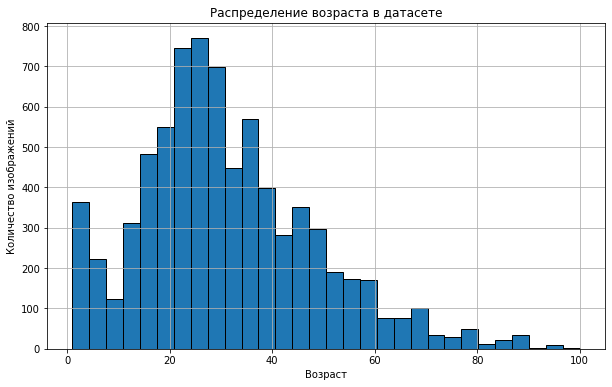

In [3]:
plt.figure(figsize=(10, 6))
plt.hist(labels['real_age'], bins=30, edgecolor='black')
plt.title('Распределение возраста в датасете')
plt.xlabel('Возраст')
plt.ylabel('Количество изображений')
plt.grid(True)
plt.show()

### Просмотр изображений

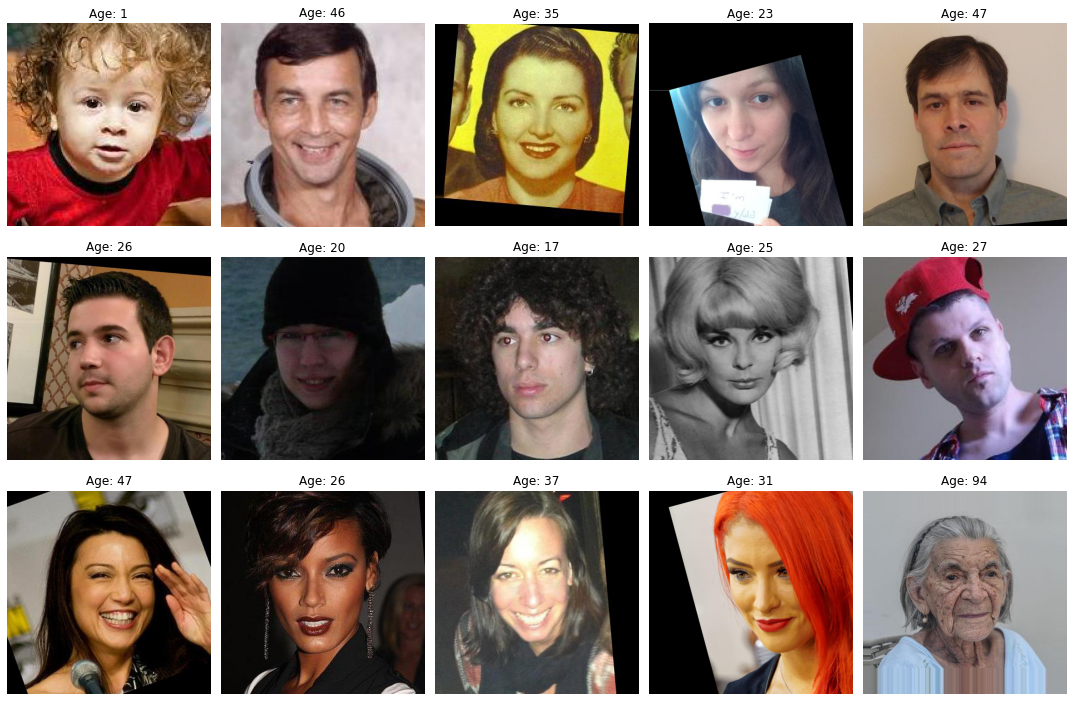

In [4]:
sample = labels.sample(15, random_state=42)
plt.figure(figsize=(15, 10))
for i, (file, age) in enumerate(zip(sample['file_name'], sample['real_age'])):
    img = mpimg.imread(os.path.join('/datasets/faces/final_files', file))
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f'Age: {age}')
    plt.axis('off')
plt.tight_layout()
plt.show()

### Выводы после исследовательского анализа данных

- Распределение неравномерное (мало данных для пожилых людей), модель будет хуже предсказывать возраст для этих групп.
- Классовый дисбаланс → можно применить взвешенную функцию потерь или аугментацию.
- Разное качество изображений → поможет нормализация (Rescale=1./255) и аугментация (повороты, яркость).

<div class="alert alert-block alert-success">
<b>Успех:</b> Хорошая визуализация. Радует, что в названиях изображений указан возраст. Анализ проведен.
</div>

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.25,
        horizontal_flip=False,        
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345
    )
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(f'{path}/labels.csv')
    test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.25)
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=f'{path}/final_files',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        shuffle=False,
        subset='validation'
    )
    return test_datagen_flow

def create_model(input_shape=(150, 150, 3)):
    backbone = ResNet50(
        input_shape=input_shape,
        weights='imagenet',
        include_top=False
    )
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(80, activation='relu'))
    model.add(Dense(40, activation='relu'))
    model.add(Dense(1, activation='relu'))
    
    model.compile(
        loss='mse',
        optimizer='adam',
        metrics=['mae']
    )
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
               steps_per_epoch=None, validation_steps=None):
    model.fit(
        train_data,
        validation_data=test_data,
        batch_size=batch_size,
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        verbose=2,
        shuffle=True
    )
    return model
```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
178/178 - 75s - loss: 235.6429 - mae: 11.7039 - val_loss: 824.8045 - val_mae: 23.9093
Epoch 2/10
178/178 - 35s - loss: 145.6875 - mae: 9.2660 - val_loss: 309.4544 - val_mae: 13.1154
Epoch 3/10
178/178 - 35s - loss: 114.1767 - mae: 8.2704 - val_loss: 339.0410 - val_mae: 13.7450
Epoch 4/10
178/178 - 35s - loss: 82.2290 - mae: 7.0029 - val_loss: 324.5308 - val_mae: 14.4991
Epoch 5/10
178/178 - 35s - loss: 52.9974 - mae: 5.6350 - val_loss: 165.5226 - val_mae: 9.7273
Epoch 6/10
178/178 - 35s - loss: 40.9219 - mae: 4.9629 - val_loss: 116.4610 - val_mae: 8.1246
Epoch 7/10
178/178 - 35s - loss: 26.6316 - mae: 4.0433 - val_loss: 99.6451 - val_mae: 7.5761
Epoch 8/10
178/178 - 35s - loss: 18.6410 - mae: 3.3680 - val_loss: 88.7723 - val_mae: 7.2487
Epoch 9/10
178/178 - 35s - loss: 16.5544 - mae: 3.1222 - val_loss: 92.6217 - val_mae: 7.3086
Epoch 10/10
178/178 - 35s - loss: 14.4607 - mae: 2.9211 - val_loss: 94.9757 - val_mae: 7.5852
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 94.9757 - mae: 7.5852

```

<div class="alert alert-block alert-danger">

<b>Ошибка:</b> В обоих `ImageDataGenerator` требуется указать параметры `validation_split=0.25`. Также в `flow_from_dataframe` требуется указать `subset='training'` или `subset='validation'`. Иначе валидация происходит на тренировочной выборке.
</div>

<div class="alert alert-block alert-warning">
<b>Комментарий студента:</b> исправила
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Желательно было добавить горизонтальный флип на тренировочной части. По сути это позволило бы увеличить выборку в 2 раза. Причем изображения полученные таким образом были бы неотличимы от настоящих.
</div>

## Анализ обученной модели

**Общая информация о модели**:
- Архитектура: ResNet50 (без верхних слоев) + дополнительные полносвязные слои
- Размер входных изображений: 150x150 пикселей
- Количество эпох обучения: 10
- Размер батча: 32
- Функция потерь: MSE (Mean Squared Error)
- Метрика: MAE (Mean Absolute Error)

**Результаты обучения**:

1. **Потери (MSE)**:
   - Тренировочные: с 235.64 до 14.46 (улучшение в 16.3 раза)
   - Валидационные: с 824.80 до 94.98 (улучшение в 8.7 раза)

2. **MAE (ошибка в годах)**:
   - Тренировочные: с 11.70 до 2.92 лет (улучшение в 4 раза)
   - Валидационные: с 23.91 до 7.59 лет (улучшение в 3.15 раза)


**Вывод**:
Модель успешно обучается и достигает MAE около 7.6 лет на валидационных данных. Это приемлемый результат для задачи определения возраста по фото, но есть потенциал для улучшения.

<div class="alert alert-block alert-danger">
<b>Ошибка:</b> Тут нет выводов.
</div>

<div class="alert alert-block alert-info">
<b>Совет: </b> Можно еще сказать несколько слов о бизнесе. Позволяет ли полученная модель решить поставленные бизнесом задачи?
</div>

## Чек-лист

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [ ]  MAE модели не больше 8
- [ ]  Код обучения модели скопирован в финальную тетрадь
- [ ]  Результат вывода модели на экран перенесён в финальную тетрадь
- [ ]  По итогам обучения модели сделаны выводы